<a href="https://colab.research.google.com/github/amithrx/Canny_Edge_Detector/blob/main/MyCannyEdgeDetectorDemo_py.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
def rgb2Gray(inputImage):
  return np.dot(inputImage[...,:3],[0.2989,0.5870,0.1140])

In [ ]:
from skimage.io import imread,imshow
from skimage.transform import resize
from skimage import data
from skimage.feature import canny
import skimage
import matplotlib.pyplot as plt
# image_gray=data.coins()-----
# image_gray2=skimage.color.rgb2gray(image_gray)
# image_gray=rgb2Gray(image_gray)
# realImage = canny(image_gray,1)-----
# image_gray=resize(image_gray,(512,480))
# image_gray = imread("test.jpg",as_gray=True)
# image_gray=resize(image_gray,(625,480))
# imshow(image_gray,cmap='gray')
# plt.imshow(image_gray,cmap='gray')---
# plt.axis('off')----
# plt.show()----
# print(image_gray.shape)-----

In [ ]:
def addPadding(inputImage,n):
  row,col=inputImage.shape
  result=np.zeros((2*(n//2)+row,2*(n//2)+col))
  for i in range((n//2),(n//2)+row):
    for j in range((n//2),(n//2)+col):
      result[i][j]=inputImage[i-n//2][j-n//2]
  return result

In [ ]:
def convolution(inputImage,kernel):
  row,col=inputImage.shape
  sizex,sizey=kernel.shape
  mid=sizex//2
  output= np.zeros((row-2*mid,col-2*mid))
  for x in range(mid,row-mid):
    for y in range(mid,col-mid):
      ans=0
      for i in range(-mid,mid+1):
        for j in range(-mid,mid+1):
          ans=ans+kernel[i+mid][j+mid]*inputImage[x+i][y+j]
      output[x-mid][y-mid]=ans
  return output

In [ ]:
def gaussian_blur(inputImage,sigma):
  row,col=inputImage.shape
  size=6*sigma+1
  mid=size//2
  kernel=np.zeros((size,size))

  for x in range(-mid,mid+1):
    for y in range(-mid,mid+1):
      kernel[x+mid][y+mid]= np.exp(-((x**2 + y**2)/(2*sigma*sigma)))/(2.0*np.pi*sigma*sigma)
  inputImage=addPadding(inputImage,size)
  new_image=convolution(inputImage,kernel)
  return new_image

# input1=gaussian_blur(image_gray,1)-----
# print(input1.shape)-----
# plt.imshow(input1,cmap='gray')-----
# plt.axis('off')-----
# plt.show()-----



In [ ]:
import math
def sobel_calc(inputImage):
  row,col=inputImage.shape
  sobel_mag = np.zeros((row,col))
  sobel_orient = np.zeros((row,col))

  # [[-1,0,1][-2,0,2][-1,0,1]] x
  # [[1,2,1][0,0,0][-1,-2,-1]] y
  #Here we need to do correlation not the convolution
  sobelx=np.array([[1,0,-1],[2,0,-2],[1,0,-1]])
  sobely=np.array([[-1,-2,-1],[0,0,0],[1,2,1]])
  
  inputImage = addPadding(inputImage,3)
  sobel_x=convolution(inputImage,sobelx)
  sobel_y=convolution(inputImage,sobely)

  for x in range(0,row):
    for y in range(0,col):
      temp=math.sqrt(sobel_x[x][y]**2+sobel_y[x][y]**2)
      sobel_mag[x][y]=temp
      if sobel_x[x][y]==0:
        sobel_orient[x][y]=(np.pi)/2
      else:
        sobel_orient[x][y]=np.arctan2(sobel_y[x][y],sobel_x[x][y])

  for x in range(0,row):
    for y in range(0,col):
      angle=(sobel_orient[x][y]*180)/np.pi
      sobel_orient[x][y]=angle
  return sobel_mag,sobel_orient
# input2,sobel_orient=sobel_calc(input1)----

# plt.imshow(input2,cmap='gray')----
# plt.axis('off')----
# plt.show()----

In [ ]:
def non_max_suppresion(image_gray,sobel_orient):
  row,col=sobel_orient.shape
  suppresion=np.zeros((row,col))
  suppresion=image_gray
  for i in range(row):
    for j in range(col):
      if(sobel_orient[i][j]>=67.5 and sobel_orient[i][j]<=90):
        val=image_gray[i][j]
        if(i-1>=0 and val<image_gray[i-1][j]):val=0
        if(i+1<row and val<image_gray[i+1][j]):val=0
        suppresion[i][j]=val

      elif(sobel_orient[i][j]>=22.5 and sobel_orient[i][j]<=67.5):
        val=image_gray[i][j]
        if(i+1<row and j-1>=0 and val<image_gray[i+1][j-1]):val=0
        if(i-1>=0 and j+1<col and val<image_gray[i-1][j+1]):val=0
        suppresion[i][j]=val
      
      elif(sobel_orient[i][j]>=-22.5 and sobel_orient[i][j]<=22.5):
        val=image_gray[i][j]
        if(j+1<col and val<image_gray[i][j+1]):val=0
        if(j-1>=0 and val<image_gray[i][j-1]):val=0
        suppresion[i][j]=val

      elif(sobel_orient[i][j]>=-67.5 and sobel_orient[i][j]<=-22.5):
        val=image_gray[i][j]
        if(i-1>=0 and j-1>=0 and val<image_gray[i-1][j-1]):val=0
        if(i+1<row and j+1<col and val<image_gray[i+1][j+1]):val=0
        suppresion[i][j]=val

      else:
        val=image_gray[i][j]
        if(i+1<row and val<image_gray[i+1][j]):val=0
        if(i-1>=0 and val<image_gray[i-1][j]):val=0
        suppresion[i][j]=val
  return suppresion

# input3=non_max_suppresion(input2,sobel_orient)----
# plt.imshow(input3,cmap='gray')-----
# plt.axis('off')-----
# plt.show()-----


In [ ]:
def double_thresholding(inputImage,highvalue):
  maxi=0
  row,col=inputImage.shape
  for i in range(row):
    for j in range(col):
      maxi=max(maxi,inputImage[i][j])
  
  output=np.zeros((row,col),dtype = bool)
  for i in range(0,row):
    for j in range(0,col):
      if inputImage[i][j]>=highvalue:
        output[i][j]=True
      else:
        output[i][j]=False
  return maxi,output

# thresholded=double_thresholding(input3)----
# plt.imshow(thresholded,cmap='gray')-----
# plt.axis('off')----
# plt.show()-----

In [ ]:
def hysteresis(output,inputImage,lowvalue):
  row,col=inputImage.shape
  for i in range(0,row):
    for j in range(0,col):
      if inputImage[i][j] >= lowvalue and output[i][j] == False:
        if(i-1>=0 and j-1>=0 and output[i-1][j-1]==True):output[i][j]=True
        elif(i-1>=0 and output[i-1][j]==True):output[i][j]=True
        elif(i-1>=0 and j+1<col and output[i-1][j+1]==True):output[i][j]=True
        elif(j-1>=0 and output[i][j-1]==True):output[i][j]=True
        elif(j+1<col and output[i][j+1]==True):output[i][j]=True
        elif(i+1<row and j-1>=0 and output[i+1][j-1]==True):output[i][j]=True
        elif(i+1<row and output[i+1][j]==True):output[i][j]=True
        elif(i+1<row and j+1<col and output[i+1][j+1]==True):output[i][j]=True
  return output

# final=hysteresis(thresholded,input3)----
# plt.imshow(final,cmap='gray')----
# plt.axis('off')----
# plt.show()----




In [ ]:
import skimage
# print(realImage.dtype)
# print(final.dtype)
def checkMetrics(realImage,final):
  print("PSNR",skimage.metrics.peak_signal_noise_ratio(realImage,final))
  print("SSIM",skimage.metrics.structural_similarity(realImage,final))
  # plt.imshow(realImage,cmap='gray')
  # plt.axis('off')
  # plt.show()

861.6707094974794
PSNR 11.47163050057587
SSIM 0.7479884615817957


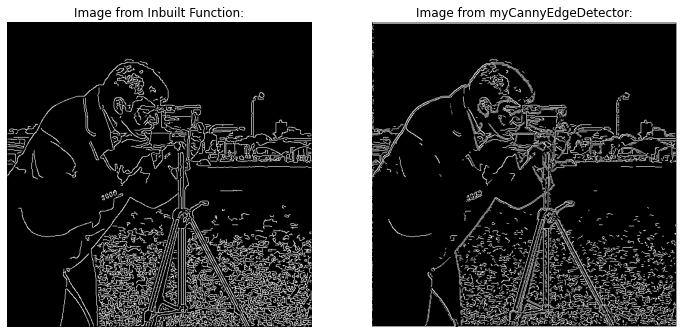

In [ ]:
def myCannyEdgeDetector(image, Low_Threshold, High_Threshold):
  if(len(image.shape)==2):
    realImage=canny(image,1)
    image_gray=image
  else:
    image1=rgb2Gray(image)
    image_gray=image1
    image2=skimage.color.rgb2gray(image)
    realImage=canny(image2,1)
 
  input1=gaussian_blur(image_gray,1)
  input2,sobel_orient=sobel_calc(input1)
  input3=non_max_suppresion(input2,sobel_orient)
  amit,thresholded=double_thresholding(input3,High_Threshold)
  print(amit)
  final=hysteresis(thresholded,input3,Low_Threshold)
  checkMetrics(realImage,final)
  fig,axes=plt.subplots(1,ncols=2,figsize=(12,6))
  axes[0].imshow(realImage,cmap='gray')
  axes[0].axis('off')
  axes[0].set_title('Image from Inbuilt Function:')
  axes[1].imshow(final,cmap='gray')
  axes[1].axis('off')
  axes[1].set_title('Image from myCannyEdgeDetector:')

image_gray=data.camera()
# image_gray=imread("test.jpg")
# var=input("Enter the Path of the Images: ")
# image_gray=imread(var)
myCannyEdgeDetector(image_gray,36.15,51)